In [34]:


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering, ranktwo_3areas

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch


size = 300
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1
rank = 10



# load a low-rank RNN
net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank)


net_lo.load_state_dict(torch.load(f'../models/3areasLowRank{rank}_{size}.pt', map_location='cpu'))


x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')


loss=0.140, acc=1.000


In [35]:
att = net_lo.__dict__
att.keys()


dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rank', 'train_m', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wrec', 'wi_full', 'wo_full', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

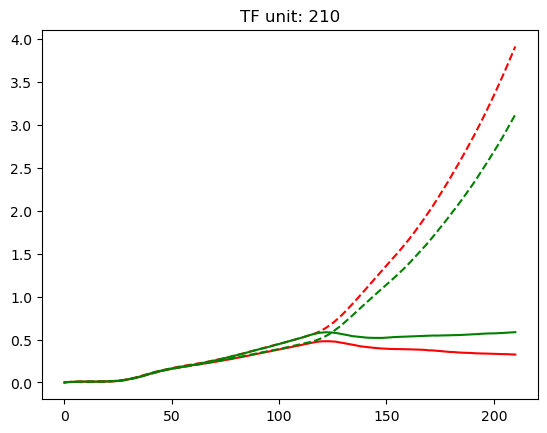

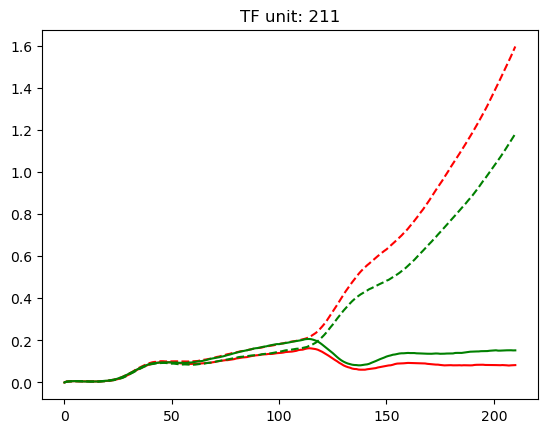

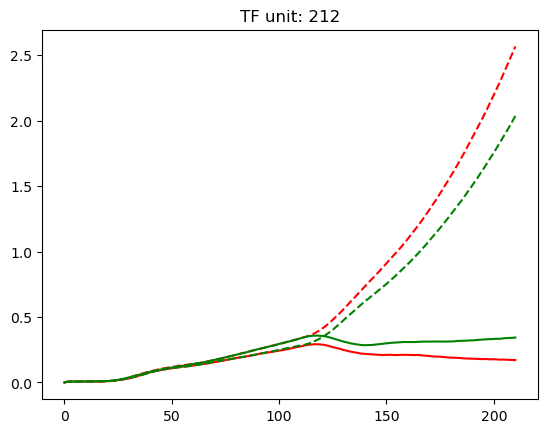

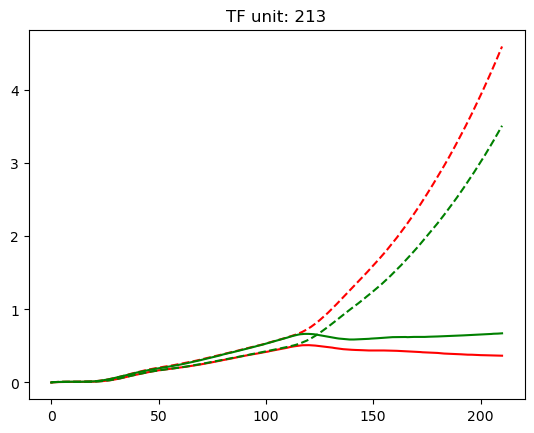

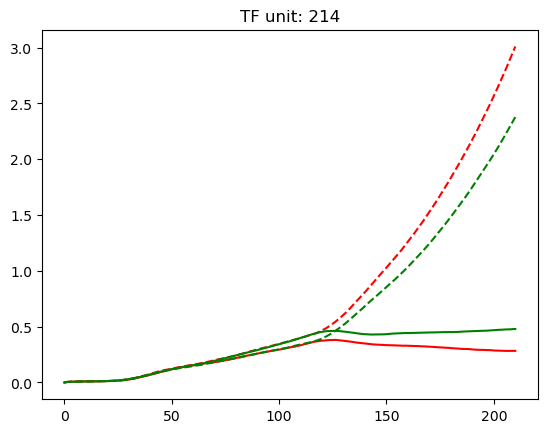

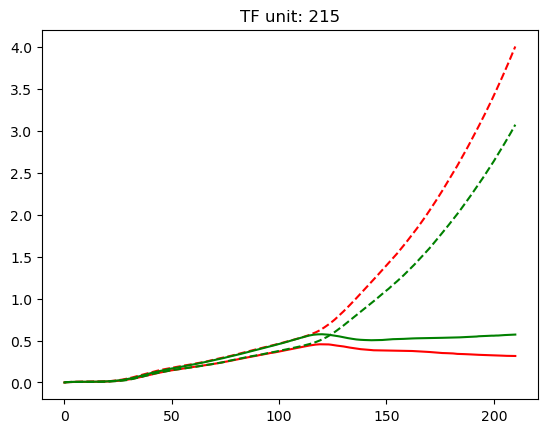

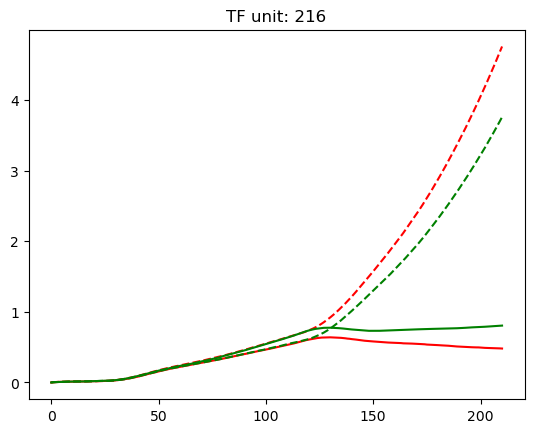

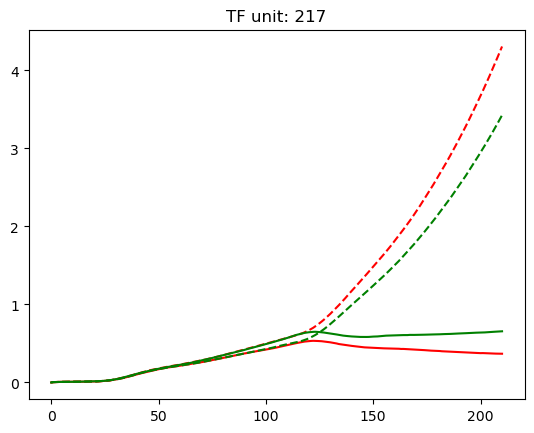

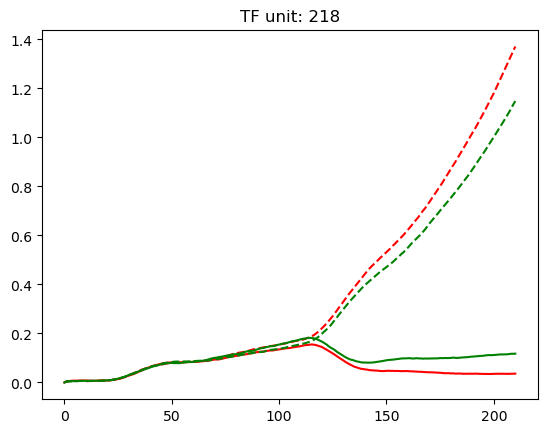

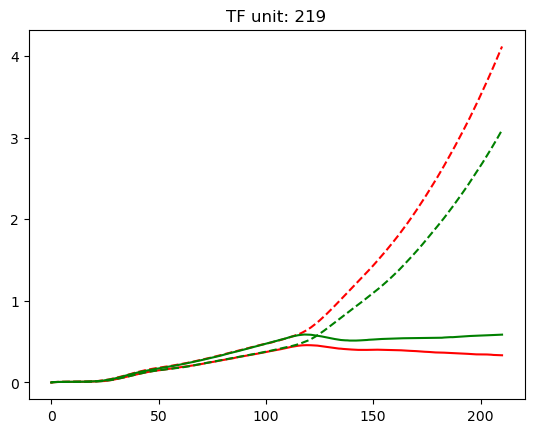

In [36]:
traj = traj.cpu()
decisions = decisions.cpu()
traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(210,220):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))

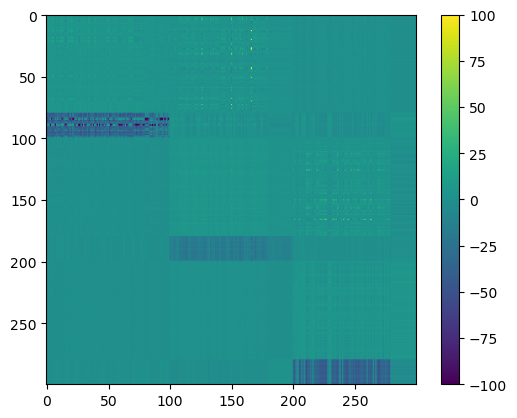

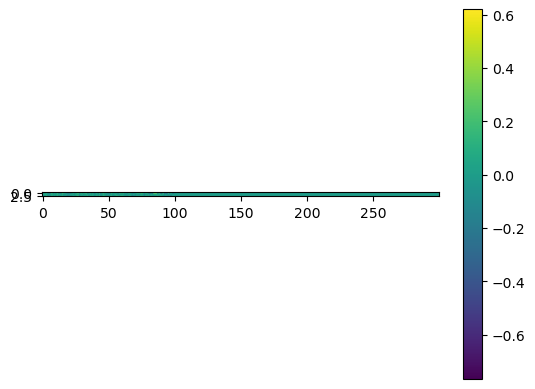

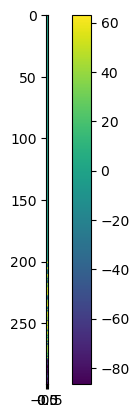

In [37]:
wrec = (net_lo.n.cpu()).matmul(net_lo.m.t().cpu())
wi = net_lo.wi.cpu()
wo = net_lo.wo.cpu()

a = wrec.detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-100, 100)
plt.show()

b = wi.detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


In [21]:
net_lo.cpu().svd_reparametrization()

# n: low-rank Wrec connectivity vector n
n = net_lo.n.cpu().detach().numpy()
# n3 = net_lo.n[:, 2].detach().numpy()
# n4 = net_lo.n[:, 3].detach().numpy()


# m: low-rank Wrec connectivity vector m
m = net_lo.m.cpu().detach().numpy()
# m3 = net_lo.m[:, 2].detach().numpy()
# m4 = net_lo.m[:, 3].detach().numpy()




In [22]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

In [23]:
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']


def projLow(trajLow, m, plotTraj): 
    # project low rank rnn traj on m vector
    kap = np.zeros((trajLow.shape[0], trajLow.shape[1], m.shape[1]))
    for ii in range(m.shape[1]):
        kap[:,:,ii] = trajLow @ m[:,ii] / size
    
    
    colors = ['red', 'red', 'green', 'green']
    lineStyle = ['-', '--', '-', '--']

    if plotTraj:
        for jj in range(kap.shape[2]):
            plt.figure()
            for i in range(4):
                plt.plot(kap[i,:,jj], c=colors[i], lw=4, ls=lineStyle[i])
            plt.title(jj)
            plt.show()

    return kap



# area 1 proj 
# kap = projLow(trajLow[:,:,:100], m[:100,:], True)

# area 2 proj 
# kap = projLow(trajLow[:,:,100:200], m[100:200,:], True)

# area 3 proj 
# kap = projLow(trajLow[:,:,200:], m[200:,:], True)

# kap = projLow(trajLow[:,:,:300], m[:300,:], True)


(844, 100)


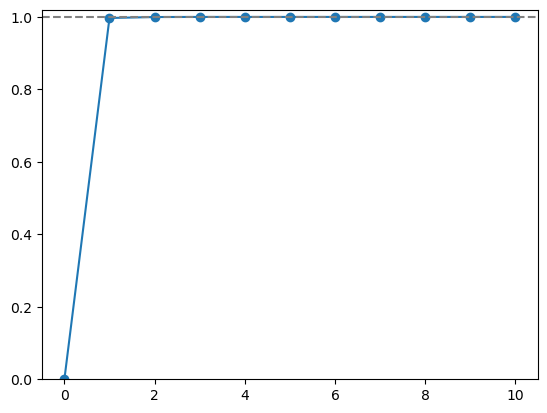

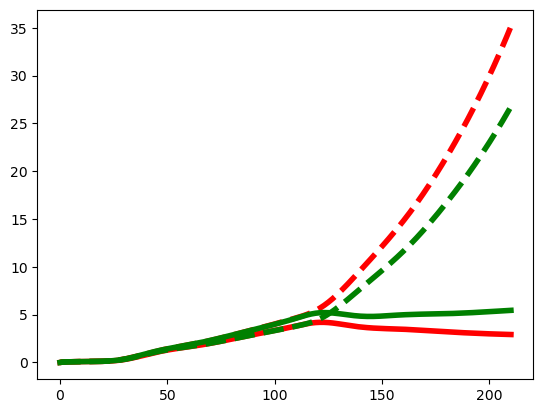

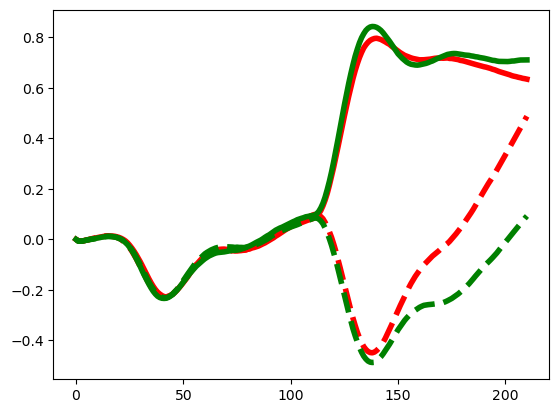

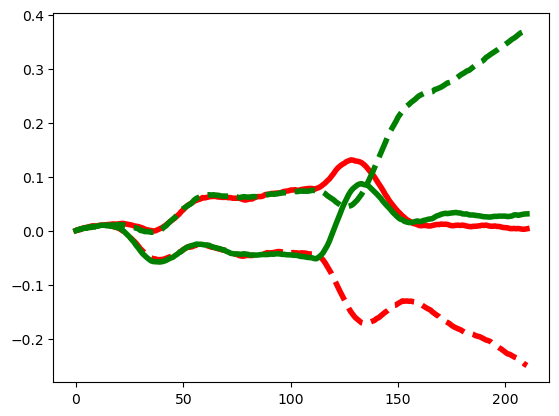

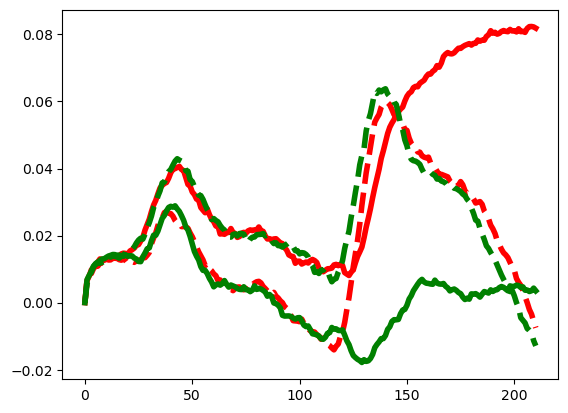

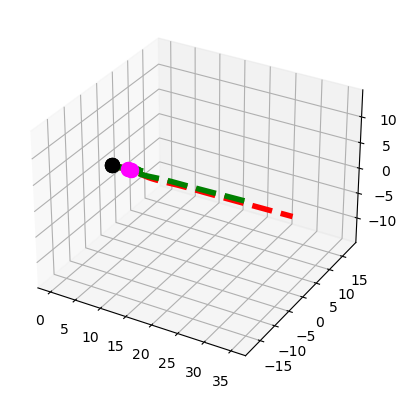

In [26]:
# low rank RNN PCA 

def areaPCA(trajLow):
    TOn = 10
    COn = 100
    
    pca = plot.pca_cumvar(trajLow, n_components=10)
    plt.ylim(0, 1.02)
    plt.axhline(1, ls='--', c='gray')
    plt.show()
    
    labels = ['RL', 'RR', 'GL', 'GR']
    
    ax1 = pca.components_[0]
    ax2 = pca.components_[1]
    ax3 = pca.components_[2]
    ax4 = pca.components_[3]
    
    k1 = trajLow @ ax1
    k2 = trajLow @ ax2
    k3 = trajLow @ ax3
    k4 = trajLow @ ax4
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
    #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
        plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
    plt.show()
    
    # 3D pca plot
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range(4):
        plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
        ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
                marker='.', s=400)
        ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
                marker='.', s=400)
    ax.axis('equal')

# area 1:
# areaPCA(trajLow[:,:,:100])
# area 2:
# areaPCA(trajLow[:,:,100:200])
# area 3:
# areaPCA(trajLow[:,:,200:])

## vector fields